In [1]:
import h5py
import numpy as np
import scipy.stats
import scipy.ndimage
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import tqdm
tqdm.tqdm_notebook()

|<bar/>| 0/? [00:00<?, ?it/s]

### Define constants and paths

In [2]:
tf_names = ["E2F6", "FOXA2", "SPI1", "CEBPB", "MAX", "NR3C1", "GABPA", "MAFK", "JUND", "REST"]
best_folds = {
    "E2F6": 4,
    "FOXA2": 7,
    "SPI1": 7,
    "CEBPB": 7,
    "MAX": 1,
    "NR3C1": 6,
    "GABPA": 7,
    "MAFK": 8,
    "JUND": 7,
    "REST": 7
}

predictions_paths = {
    tf_name: {
        fold: "/users/amtseng/tfmodisco/results/FROM_NAUTILUS/results/peak_predictions/{0}/{0}_peak_prediction_performance_fold{1}.h5".format(tf_name, fold)
        for fold in range(1, 11)
    } for tf_name in tf_names
}
performance_bounds_paths = {
    tf_name: "/users/amtseng/tfmodisco/results/performance_bounds/{0}/{0}_performance_bounds.h5".format(tf_name)
    for tf_name in tf_names
}

chrom_splits_json = "/users/amtseng/tfmodisco/data/processed/ENCODE/chrom_splits.json"
with open(chrom_splits_json, "r") as f:
    chrom_splits = json.load(f)

In [3]:
input_length = 1346
profile_length = 1000

### Import the set of performance metrics
For each peak, get the actual performance metrics, the lower bounds, and the upper bounds. The coordinates in the files should match exactly\*

\*The saved coordinates in the predictions/actual performances are padded to the input length, but the coordinates in the performance bounds are padded to the profile length

In [4]:
tf_name = tf_names[0]
predictions_path = predictions_paths[tf_name][best_folds[tf_name]]
performance_bounds_path = performance_bounds_paths[tf_name]

pred_reader = h5py.File(predictions_path, "r")
perf_bound_reader = h5py.File(performance_bounds_path, "r")

In [5]:
perf_bound_reader["coords"]["coords_start"][:10]

array([778389, 869409, 904324, 904964, 920724, 923376, 924157, 924385,
       924934, 938812])

In [6]:
pred_reader["coords"]["coords_start"][:10]

array([778216, 869236, 904151, 904791, 920551, 923203, 923984, 924212,
       924761, 938639])

In [7]:
pred_reader_coords = pred_reader["coords"]
perf_bound_reader_coords = perf_bound_reader["coords"]

In [8]:
def import_tf_metrics(tf_name):
    """
    Imports the set of all metrics for the given TF. Returns a dictionary of the
    following format:
        `actual_perf`:
            `fold_num`:
                `nll`: ...
                `norm_nll`: ...
                ...
            `fold_num`:
                ...
        `lower_perf`:
            ...
        `upper_perf`:
            ...
    """
    perfs = {}
    
    performance_bounds_path = performance_bounds_paths[tf_name]
    perf_bound_reader = h5py.File(performance_bounds_path, "r")
    
    perf_bound_reader_coords = perf_bound_reader["coords"]
    lower_perf = perf_bound_reader["performance_lower"]
    upper_perf = perf_bound_reader["performance_upper"]
    lower_perf_dict = {key : lower_perf[key][:] for key in lower_perf.keys()}
    upper_perf_dict = {key : upper_perf[key][:] for key in upper_perf.keys()}
    perfs["lower_perf"] = lower_perf_dict
    perfs["upper_perf"] = upper_perf_dict
    perfs["actual_perf"] = {}

    for fold in tqdm.notebook.trange(1, 11):
        predictions_path = predictions_paths[tf_name][fold]
        pred_reader = h5py.File(predictions_path, "r")

        # Check that the coordinates match up exactly
        pred_reader_coords = pred_reader["coords"]
        assert np.all(
            pred_reader_coords["coords_end"][:] - pred_reader_coords["coords_start"][:] == input_length
        )
        assert np.all(
            perf_bound_reader_coords["coords_end"][:] - perf_bound_reader_coords["coords_start"][:] ==
            profile_length
        )
        assert np.all(
            perf_bound_reader_coords["coords_start"][:] - ((input_length - profile_length) // 2) ==
            pred_reader_coords["coords_start"][:]
        )
        assert np.all(
            perf_bound_reader_coords["coords_end"][:] + ((input_length - profile_length) // 2) ==
            pred_reader_coords["coords_end"][:]
        )
        assert np.all(
            perf_bound_reader_coords["coords_chrom"][:] == pred_reader_coords["coords_chrom"][:]
        )

        actual_perf = pred_reader["performance"]
        actual_perf_dict = {key : actual_perf[key][:] for key in actual_perf.keys()}

        # Compute the normalized NLL for the actual performance 
        actual_perf_dict["norm_nll"] = actual_perf_dict["nll"][:] / \
            np.mean(np.sum(pred_reader["predictions"]["true_profs"][:], axis=2), axis=2)

        perfs["actual_perf"][fold] = actual_perf_dict
        pred_reader.close()
        
    perf_bound_reader.close()
    
    return perfs

### Plot the performance bounds

In [9]:
def plot_perf_bounds(tf_perfs):
    def create_violins(ax, lower_perfs, actual_perfs_list, upper_perfs):
        num_actual_perfs = len(actual_perfs_list)
        all_data = np.stack([lower_perfs] + actual_perfs_list + [upper_perfs], axis=0)
        q1, med, q3 = np.nanpercentile(all_data, [25, 50, 70], axis=1)
        iqr = q3 - q1
        upper_outlier = q3 + (1.5 * iqr)
        lower_outlier = q1 - (1.5 * iqr)
        sorted_clipped_data = [
            np.sort(np.clip(vec[np.isfinite(vec)], lower_outlier[i], upper_outlier[i]))
            for i, vec in enumerate(all_data)
        ]
        
        plot_parts = ax.violinplot(
            sorted_clipped_data, showmeans=False, showmedians=False, showextrema=False
        )
        violin_parts = plot_parts["bodies"]
        violin_parts[0].set_facecolor("red")
        violin_parts[0].set_edgecolor("red")
        violin_parts[0].set_alpha(0.7)
        for i in range(1, num_actual_perfs + 1):
            violin_parts[i].set_facecolor("blue")
            violin_parts[i].set_edgecolor("blue")
            violin_parts[i].set_alpha(0.7)
        violin_parts[-1].set_facecolor("green")
        violin_parts[-1].set_edgecolor("green")
        violin_parts[-1].set_alpha(0.7)
        
        inds = np.arange(1, num_actual_perfs + 2 + 1)
        ax.vlines(inds, q1, q3, color="black", linewidth=5, zorder=1)
        ax.scatter(inds, med, marker="o", color="white", s=30, zorder=2)
    
    # Profile metrics
    for metric_key, metric_name in [
        ("nll", "NLL"), ("norm_nll", "Normalized NLL"), ("jsd", "JSD"), ("profile_mse", "Profile MSE"),
        ("profile_pearson", "Profile Pearson"), ("profile_spearman", "Profile Spearman")
    ]:
        lower_perfs = np.nanmean(tf_perfs["lower_perf"][metric_key], axis=1)
        upper_perfs = np.nanmean(tf_perfs["upper_perf"][metric_key], axis=1)
        actual_perfs_list = [
            np.nanmean(tf_perfs["actual_perf"][fold][metric_key], axis=1)
            for fold in range(1, 11)
        ]
        fig, ax = plt.subplots(figsize=(20, 5))
        create_violins(ax, lower_perfs, actual_perfs_list, upper_perfs)
        ax.set_title("%s of %s predictions across folds\nGenome-wide performance" % (metric_name, tf_name))
        ax.set_xticks(np.arange(1, 13))
        ax.set_xticklabels(
            ["Randomized profiles"] + ["Fold %d" % (fold + 1) for fold in range(1, 11)] + ["Pseudoreplicates"]
        )
        plt.show()
        
    # Count metrics
    for metric_key, metric_name in [
        ("count_mse", "Count MSE"), ("count_pearson", "Count Pearson"), ("count_spearman", "Count Spearman")
    ]:
        lower_bound = np.nanmean(tf_perfs["lower_perf"][metric_key])
        upper_bound = np.nanmean(tf_perfs["upper_perf"][metric_key])
        actual_perfs_list = [
            np.nanmean(tf_perfs["actual_perf"][fold][metric_key]) for fold in range(1, 11)
        ]
        fig, ax = plt.subplots(figsize=(20, 5))
        
        label_locs = np.arange(12)  # Location of labels
        
        ax.bar(
            label_locs, [lower_bound] + actual_perfs_list + [upper_bound],
            color=(["red"] + (10 * ["blue"]) + ["green"]), alpha=0.7
        )
        ax.set_title("%s of %s predictions across folds\nGenome-wide performance" % (metric_name, tf_name))
        ax.set_xticks(label_locs)
        ax.set_xticklabels(
            ["Randomized profiles"] + ["Fold %d" % (fold + 1) for fold in range(1, 11)] + ["Pseudoreplicates"]
        )
        plt.show()

In [10]:
perfs = import_tf_metrics("E2F6")

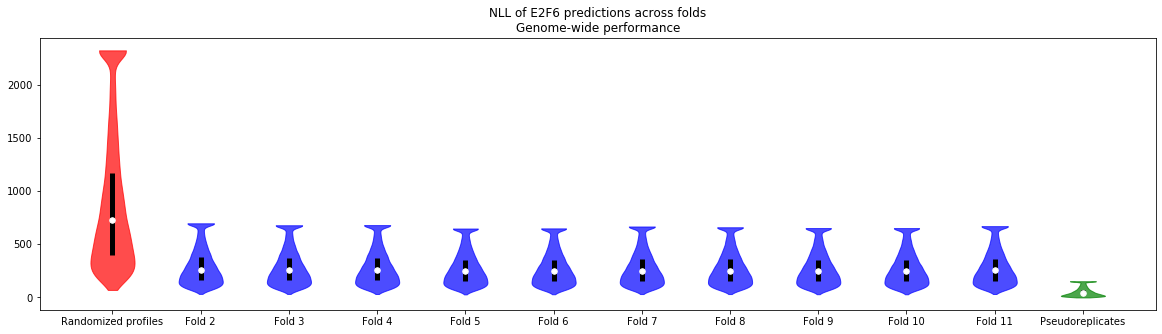

/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


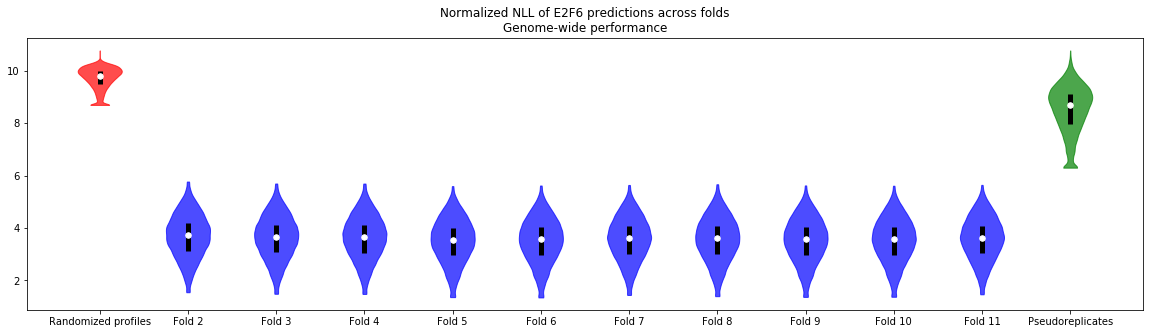

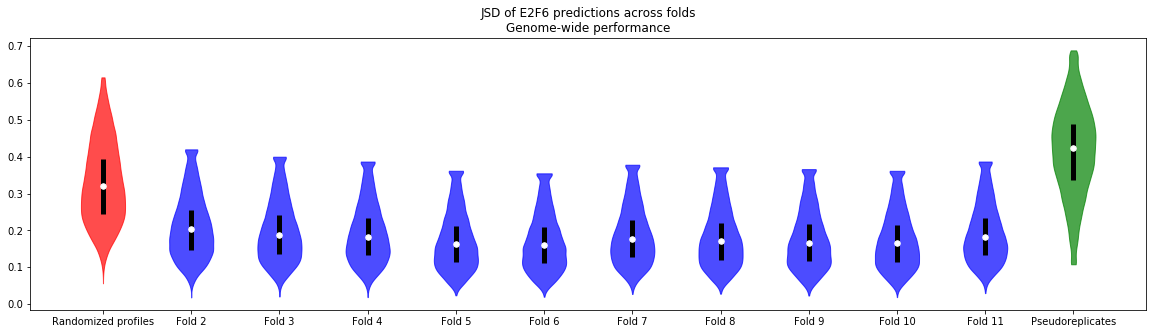

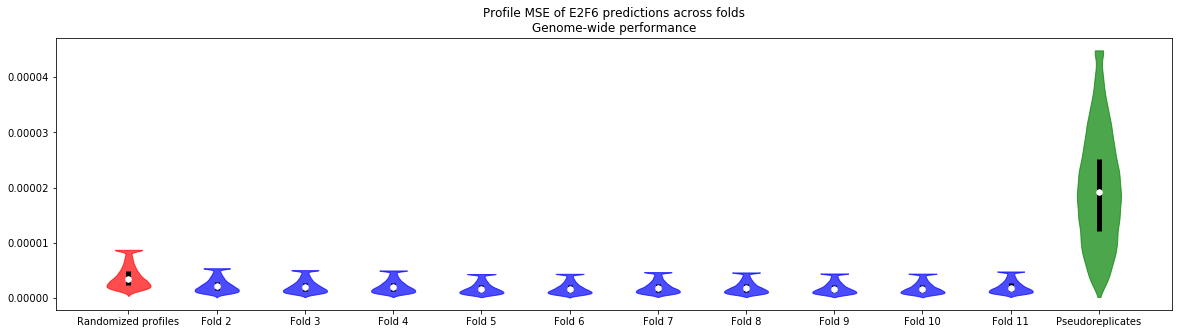

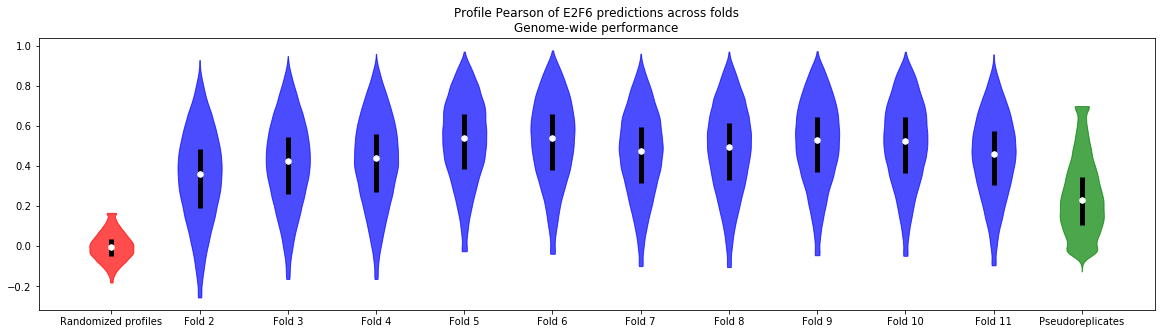

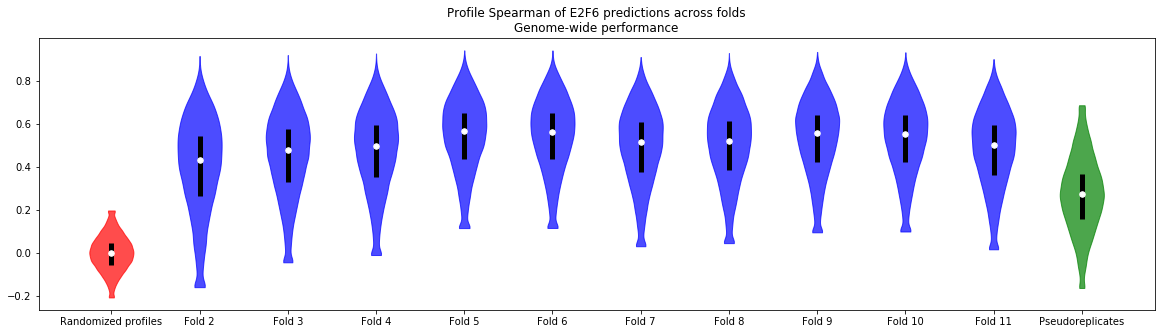

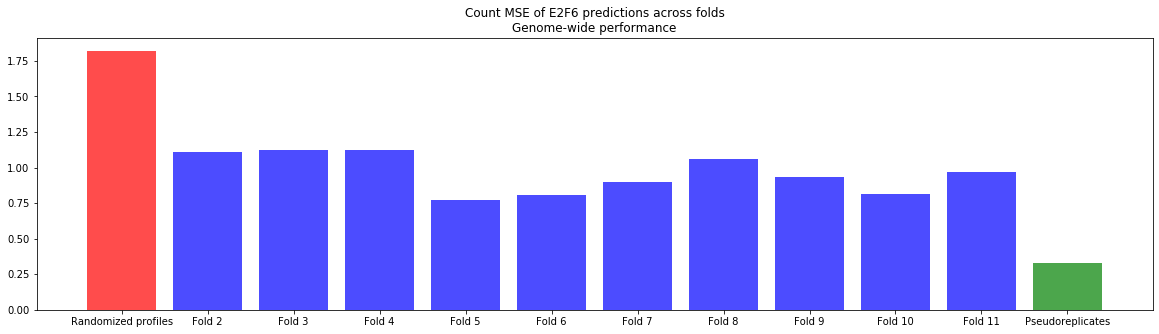

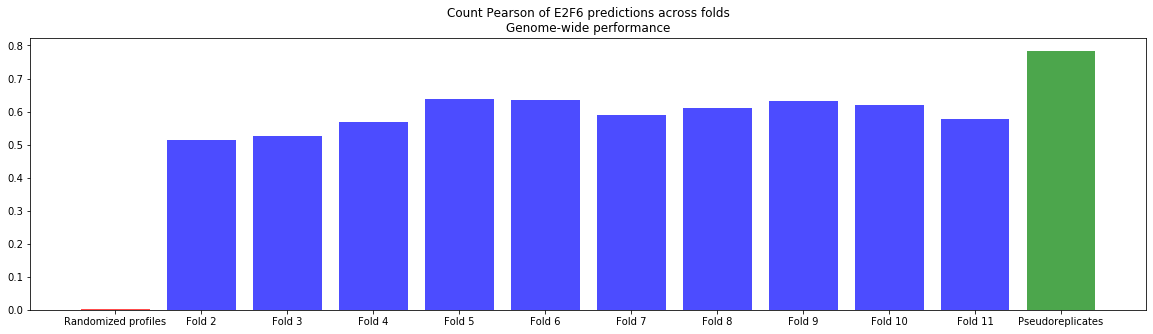

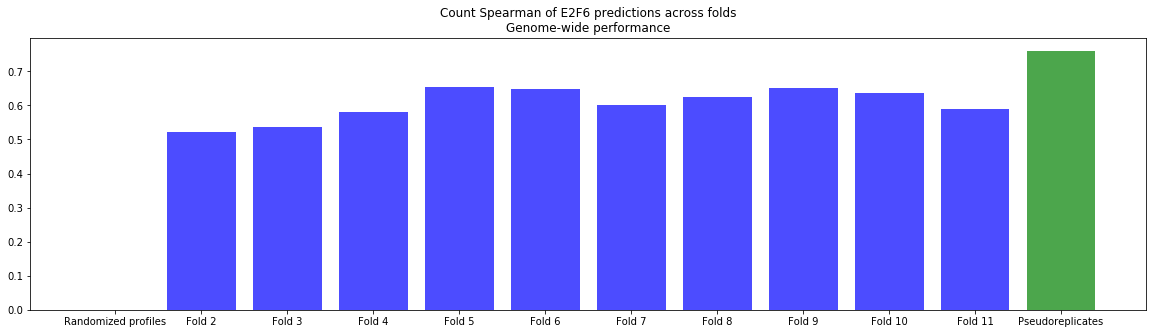

In [11]:
plot_perf_bounds(perfs)

In [12]:
predictions_path = predictions_paths["E2F6"][5]
performance_bounds_path = performance_bounds_paths["E2F6"]
replicate_profs_path = "/users/amtseng/tfmodisco/data/processed/ENCODE/labels/E2F6/E2F6_pseudorep_profiles.h5"

pred_reader = h5py.File(predictions_path, "r")
perf_bound_reader = h5py.File(performance_bounds_path, "r")
replicate_profs_reader = h5py.File(replicate_profs_path, "r")

In [21]:
def plot_coord(coord_index):
    chrom = perf_bound_reader["coords"]["coords_chrom"][coord_index].decode()
    start = perf_bound_reader["coords"]["coords_start"][coord_index]
    end = perf_bound_reader["coords"]["coords_end"][coord_index]
    print(chrom, start, end)
    
    replicates = replicate_profs_reader[chrom][start:end]
    num_tasks = replicates.shape[1]
    
    def smooth(track, axis=-1):
        return scipy.ndimage.gaussian_filter1d(                         
            track, 7, axis=axis, truncate=((81 - 1) / (2 * 7))
        )
    
    replicates_smooth = smooth(replicates, axis=0)
    
    fig, ax = plt.subplots(num_tasks, figsize=(15, num_tasks * 4))
    if num_tasks == 1:
        ax = [ax]
    for i in range(num_tasks):
        ax[i].plot(replicates[:,i,0,0], color="royalblue", alpha=0.5)
        ax[i].plot(-replicates[:,i,0,1], color="goldenrod", alpha=0.5)
        ax[i].plot(replicates[:,i,1,0], color="darkslateblue")
        ax[i].plot(-replicates[:,i,1,1], color="darkorange")
    plt.show()
    
    true_profs = pred_reader["predictions"]["true_profs"][coord_index]
    pred_profs = np.exp(pred_reader["predictions"]["log_pred_profs"][coord_index])
    true_profs = true_profs / np.sum(true_profs, axis=1, keepdims=True)
    pred_profs = pred_profs / np.sum(pred_profs, axis=1, keepdims=True)
    true_profs_smooth = smooth(true_profs, axis=1)
    pred_profs_smooth = smooth(pred_profs, axis=1)
    fig, ax = plt.subplots(num_tasks, figsize=(15, num_tasks * 4))
    if num_tasks == 1:
        ax = [ax]
    for i in range(num_tasks):
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(-true_profs[i,:,1], color="goldenrod", alpha=0.5)
        ax[i].plot(pred_profs[i,:,0], color="darkslateblue")
        ax[i].plot(-pred_profs[i,:,1], color="darkorange")
    plt.show()
    
    for i in range(num_tasks):
        print(scipy.spatial.distance.jensenshannon(np.ravel(replicates_smooth[:,i,0]), np.ravel(replicates_smooth[:,i,1])))
    print(np.sqrt(perf_bound_reader["performance_upper"]["jsd"][coord_index]))
        
    for i in range(num_tasks):
        print(scipy.spatial.distance.jensenshannon(np.ravel(true_profs_smooth[i]), np.ravel(pred_profs_smooth[i])))
    print(np.sqrt(pred_reader["performance"]["jsd"][coord_index]))

chr17 27566905 27567905


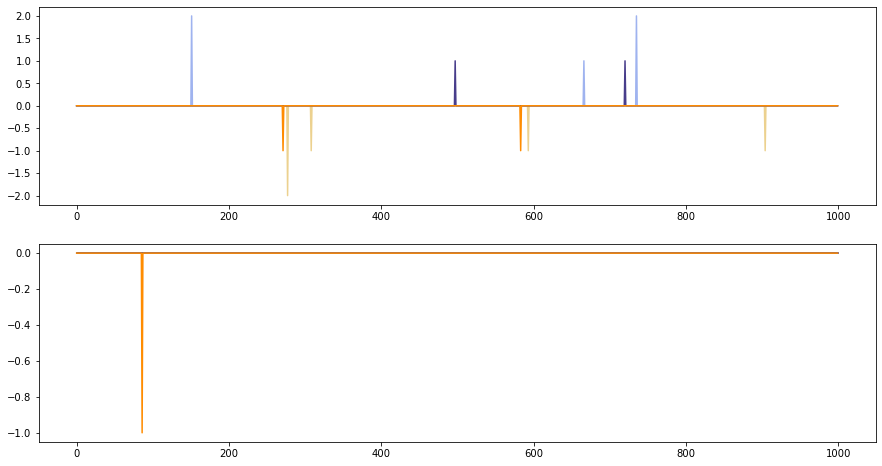

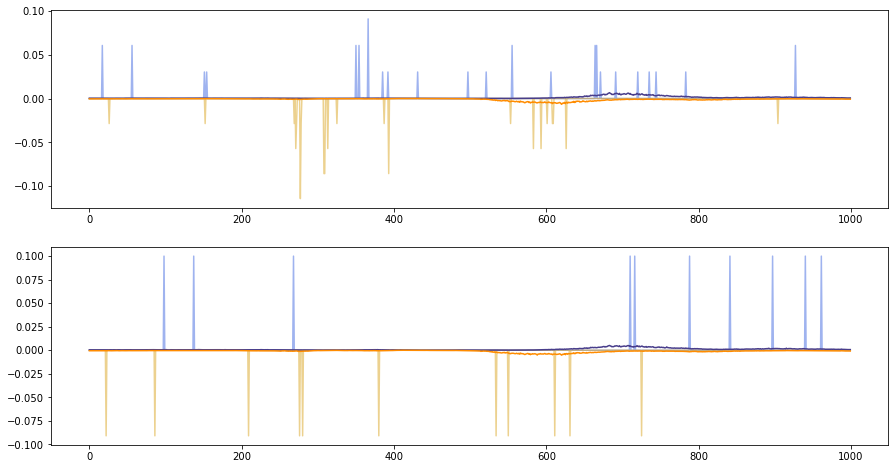

0.6401913966520523
nan
[0.63497689        nan]
0.5676926242160629
0.5486925671529189
[0.56769262 0.54869257]


/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/scipy/spatial/distance.py:1288: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sum(p, axis=0)


In [24]:
plot_coord(12345)